# Simple Postion Reconstruction
(author: B.Paetsch, date: 17.06.2020)

new: position function, exception handling in Waveform function

idea position reconstruction: The z-position is calculated with the product of the drift velocity (1.73 mm/microsec) and the time difference between the S1 and S2 signal (drift time). We only look at events that first of all have a valid pulse found by the Peaks-function (Joey). Then we create a s1s2-list with all pulses divided into S1 and S2 pulses (right now we only have a width criterion (smaller then 80 ns for S1)). Only events where we have both a S1 and a S2 peak are added to our s1s2-list. The position-function then calls the Waveform-reader (Joey), which creates a list of the channels that contributed most to the signals in one event and additionally determines the channel with the largest contribution (minchannel: lowest adc value). For the x- and y-position, the position of the PMT in minchannel (largest peak) is taken (regardless whether it is a top or bottom PMT and whether the largest peak was a S1 or S2 peak. (maybe we want to specify that -> additional criteria???)).

exception handling: For those events which have a waveform size larger than 350000 ns (large scintillation signal ), an exception handling is added to the Waveform-function, which skipps these kind of events and counts them (counter isn't working properly yet, sorry). One example of those events is event number 23 in NG.

In [92]:
"""same as before"""

import Zip
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
import math


# Channels in the detector
det_ch = { 'tpc': list(range(0, 247+1)), 'veto': list(range(248, 253+1)), 
          'sum_wv': [254], 'busy_on': [255], 'busy_off': [256],
          'hev_on': [257], 'hev_off': [258], 'muon_veto_trigger': [259], } 
n_channels = 260

# Initial parameters
baseline_ = 16384. * np.ones(n_channels)
std_ = 2.3 * np.ones(n_channels)

# The data files
NG = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/NG") # Neutron data
Rn220 = Zip.ReadZipped("/data/nikhefproject/data/xenon1t/Rn220") # Rn-220 data

In [184]:
"""I added the exception handling"""

# A waveform reader function
def Waveform(raw,eventnr,counter):
    event = raw.get_single_event(eventnr)
                                
    #The variables that check if a channel is the minimum channel
    adcmin = 16382
    minchannel = 0
    
    #A list that holds all the channels with significant pulses 
    channellist = []
    
    #Create the datapoint arrays
    n = 350000  
    ts = np.ones((n_channels, n), dtype=np.int16)
    ts = ts * 16382 
    t = np.linspace(0, n, n) 
    
    #Loop over all pulses in the event
    for p in event.pulses:
        ch = p.channel
        i = np.zeros(n_channels, dtype = int)
        #print(p.channel, ": ", p.left, p.right-p.left)
        for adc in p.raw_data:
            try:
                c = 0
            #Add the ADC value to the appropriate channel array
                ts[ch][p.left + i[ch]] = adc
                i[ch] = i[ch] + 1
            except IndexError:
                if c == 0:
                    counter += 1
                pass
            #Append all significant main channels to the list
            if adc < 15000 and ch not in channellist and ch in det_ch['tpc']:
                channellist.append(ch)
                
            #Check which channel is the minimum channel
            if adc < adcmin:
                adcmin = adc
                minchannel = ch
                
    #Sort for convenience
    channellist.sort()
    return t, ts, channellist, minchannel, counter

In [124]:
"""same as before"""

def Peaks(pulse):
    
    # The standard variables
    q = 0
    left_t, right_t = 0, 0
    baseline = 16382.
    std = 2.3
    ch = pulse.channel
    wave = pulse.raw_data
    
    # The index for the minimum
    minindex = pulse.right
    
    # Variables for the averages
    ratio = 1
    avfound = 0
    samplelist = []

    s = np.std(wave)
    delta = baseline - np.min(wave)
    if min(s, delta) > 5*std:
        for samples in enumerate(wave):
            base_sub = samples[1] - baseline
            if abs(base_sub) > 5*std:
                q = q + base_sub
             
            # Compute the average of the previous samples
            av = np.average(samplelist)
            
            # left_t is assigned when a significant deviation from the average is recorded
            if abs(samples[1] - av) > 20 and left_t == 0:
                left_t = samples[0]
                avfound = av
             
            # Find the index for the minimum
            if samples[1] == np.min(wave):
                minindex = samples[0]

            # right_t is assigned in a similar way as left_t
            if abs(samples[1] - avfound) < 20 and samples[0] > minindex and right_t == 0: 
                right_t = samples[0]
                
            # Add the current sample to the sample list
            samplelist.append(samples[1])
        ratio = np.min(wave)/int(avfound)
    else:
        baseline = np.average(wave)
        std = s
    width = right_t - left_t 
    if width != 0 and -q/width < 3*std or ratio >= 0.99:
        q = 0
    return (ch, q, width, pulse.left+left_t, ratio)

In [226]:
"""same as in XAMS, only with <80ns as width criterion 
(80ns: I found that number when plotting the widths for all pulses in Peaks-list)"""

def S1S2classification(raw):
    event_sum_list = []
    for event in raw.get_events():
        s1 = 0
        s2 = 0
        s1t0 = 0
        s2t0 = 0
        for p in event.pulses:
            if p.channel == 254:
                (ch, q, width, t0, ratio) = Peaks(p)
                if q < 0:
                    if width < 80: # Separate S1 from S2
                        if s1 == 0:
                            s1 = -q # we implicity ignore any 2nd S1
                            s1t0 = t0   
                    else:
                        if s2 == 0:
                            s2t0 = t0 #only save time first s2
                        s2 = s2 - q # Sum all the S2
                    
        if (s1 and s2): #only events we both a S1 and a S2 peak
            event_sum = { 'eventnumber': event.event_number, 's1': s1, 's2': s2, 
                     's1t0': s1t0, 's2t0': s2t0 }
            event_sum_list.append(event_sum)
        if event.event_number == 10000:
            break
    return event_sum_list    

In [126]:
#have a look at the S1S2classification
S1S2list = S1S2classification(NG)
print(S1S2list[0])
print(S1S2list[0]['eventnumber'])
print(len(S1S2list))

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'eventnumber': 0, 's1': [110469.0], 's2': [1311152.0], 's1t0': [100055], 's2t0': [171748]}
0
11


In [ ]:
#you need the Waveform-, Peaks- and S1S2classification-function for running the position-function
def position(raw,s1s2,counter):
    """ Finding the x,y and z position for an event, and storing the coordinates in a list.
    Only channel 254 is used."""
    
    from configparser import ConfigParser, ExtendedInterpolation
    config = ConfigParser(inline_comment_prefixes='#', interpolation=ExtendedInterpolation(), strict=True)
    config.optionsxform = str
    config.read('xenon1t.ini')
    
    position_list = []
    z = 0
    drift_velocity = 1.73 # mm/us, see Erik p.89
    
    for event in s1s2_list:
    #z-coordinate
        #try:
        drift = 2e-3*(event['s2t0']-event['s1t0']) #why 2e-3??
        z = drift * drift_velocity #[mm]
        #except IndexError:
        #    pass
    
    #x-,y-coordinate (we take the position of the minchannel PMT)
        (t, ts, channellist, minchannel, counter) = Waveform(raw,event['eventnumber'],counter)
        pmt = eval(config['DEFAULT']['pmts'])
        x = pmt[minchannel]['position']['x']
        y = pmt[minchannel]['position']['y']
        
        entry = { 'eventnumber': event['eventnumber'], 'x': x, 'y': y, 
                     'z': z }
        position_list.append(entry)
    
        if event['eventnumber']%10==0:
            print(event['eventnumber'])
        if event['eventnumber']==10000:
            break
            
    return position_list, counter #counter: how many events we skipped in Waveform-fct. due to a size>350000 

In [229]:
#create a list with all s1 and s2 event (equals the event_sum_list in Xams_signals.ipynb)
"""change the number of events you want to look at in S1S2classification
 (10000 events = 53 min runtime for S1S2clas and = min runtime for position on top) """

import time
start_time = time.time()
raw = NG

s1s2_list = S1S2classification(raw)

print("execution runtime: ", time.time()-start_time) #seconds

/usr/lib/python3/dist-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/lib/python3/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


execution runtime:  3197.6487715244293


In [ ]:
#create the position_list
start_time = time.time()

position_list, counter = position(raw,s1s2_list,0)

print("execution runtime: ", time.time()-start_time) #seconds

0.0


In [215]:
print(counter)
"""counter isn't working properly yet (it indicates the length of the waveform part that didn't fit)
 should indicate the number of events that were skipped...
 NG: event 23 has a length of 350000 + 185342 = 535342 """

print(len(position_list))
print(position_list[0])

185342
63
{'eventnumber': 0, 'x': 25.305737393552118, 'y': 32.979079049733606, 'z': 248.05777999999998}


In [216]:
print(position_list[0]['x'])

25.305737393552118


Text(0.5,0,'drift[ns]')

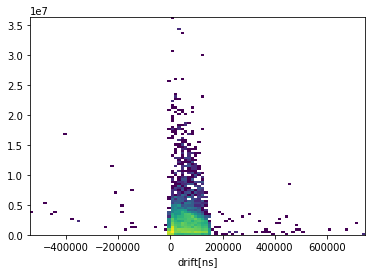

In [237]:
#plotting the drift time
s1 = []
s2 = []
drift = []
for event in s1s2_list:
    drift.append(2*(event['s2t0']-event['s1t0'])) #why 2 times?
    s1.append(event['s1'])
    s2.append(event['s2'])
fig, ax = plt.subplots()
ax.hist2d(drift,s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax.set_xlabel("drift[ns]")
#fname = 'drifttimeFirst10000Peaks.png'
#fig.savefig(fname, dpi = (200))

Text(0,0.5,'S2')

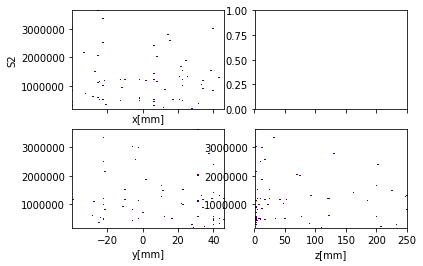

In [225]:
#plotting the x-, y- and z-coordinate
x = []
y = []
z = []
for position in position_list:
    #print(position)
    x.append(position['x'])
    y.append(position['y'])
    z.append(position['z'])
    #print(position['eventnumber'])
    #listindex = s1s2_list.index(position['eventnumber'])
    #s2.append(s1s2_list[position.index()]['s2'])
        
fig, ax = plt.subplots(3, 1, sharex='col')
ax[0].hist2d(x,s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax[1].hist2d(y,s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax[2].hist2d(z,s2, bins=(100,100), norm=mpl.colors.LogNorm())
ax[0].set_xlabel("x[mm]")
ax[1].set_xlabel("y[mm]")
ax[2].set_xlabel("z[mm]")
ax[0].set_ylabel("S2")
ax[1].set_ylabel("S2")
ax[2].set_ylabel("S2")

# Outlook

-now we use the signal of channel 254 (top+bottom) for the S1 and S2 signals for the z-coordinate 

-in arXiv:1712.05696 they only use the S2 signal for the x- and y-coordinate (minchannel looks at minimal adc value in general). Shall we also use only S2 signals when looking for minchannel???? ......

-S1S2classification: only width criterion so far and at least one S1 and one S2 signal in event. More criteria??.... 
